# CNN Architectures and Pretrained Models Trials

## Imports

In [1]:
import keras
import tensorflow as tf

from glob import glob
import random, os, datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

## Customized Functions

In [2]:
def get_image_paths(root_dir, num_images=None):
    all_images = []
    
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
        
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))

def display_images(img_list):
    plt.figure(figsize=(15, 6))
    
    for i, img_path in enumerate(img_list):
        img = image.load_img(img_path)
        img = image.img_to_array(img, dtype=np.uint8)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.squeeze())
        plt.axis('off')
        plt.title(f'Image {i+1}')
        
    plt.tight_layout()
    plt.show()


def print_predicted_classes(predicted_classes):
    
    for full_path, (label, probability) in predicted_classes.items():
        filename = os.path.basename(full_path)
        print(f"{filename}: {label} ({probability:.2f}%)")

## Data

In [3]:
dir_path = '../imagenet_samples'
img_list = get_image_paths(dir_path)
len(img_list)

40

In [4]:
get_image_paths(dir_path, 5)

['/content/drive/MyDrive/Colab Notebooks/04_convolutional_neural_network/datasets_and_files/imagenet_samples/Eskimo_dog.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/04_convolutional_neural_network/datasets_and_files/imagenet_samples/puck.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/04_convolutional_neural_network/datasets_and_files/imagenet_samples/projector.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/04_convolutional_neural_network/datasets_and_files/imagenet_samples/cock.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/04_convolutional_neural_network/datasets_and_files/imagenet_samples/trailer_truck.jpeg']

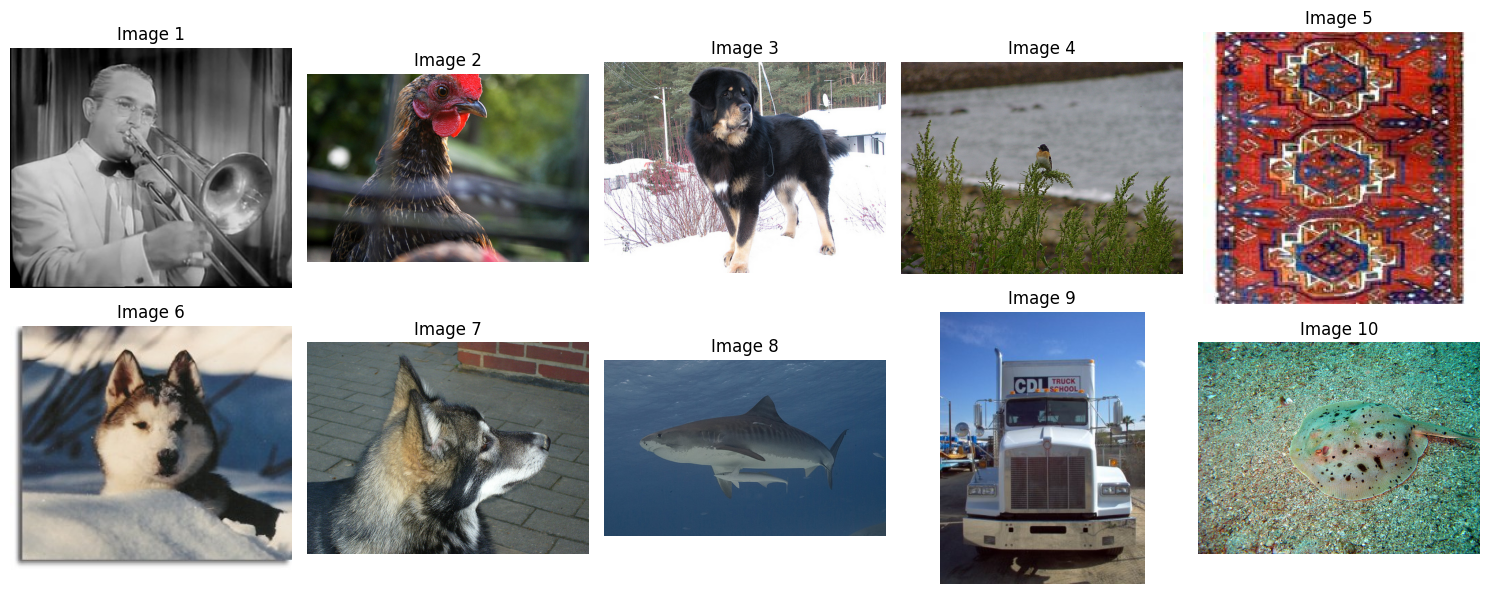

In [5]:
img_list = get_image_paths(dir_path, 10)
display_images(img_list)

## VGG16
<u>***NOTE:***</u> **First of all, we need to convert our images into the size information (AxA pixels) of the images in the dataset on which this model was trained, and then bring the data preprocessing function that was used when training this model.**

In [6]:
from keras.applications.vgg16 import VGG16, preprocess_input as preprocess_input_vgg16, decode_predictions as decode_vgg16

In [7]:
def preprocess_vgg16(img_path):
    img = image.load_img(img_path, target_size=(224, 224))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_array = preprocess_input_vgg16(img_array)

    return img_array

In [8]:
def predict_vgg16(model, img_array):

    predictions = model.predict(img_array, verbose=0)

    top_predictions = decode_vgg16(predictions, top=1)[0][0]

    label, probability = top_predictions[1], top_predictions[2]

    return label, probability

In [9]:
def visualise_preds_vgg16(model, image_paths, visualize=False):
    results = {}

    for img_path in image_paths:

        img_array = preprocess_vgg16(img_path)

        label, probability = predict_vgg16(model, img_array)

        results[img_path] = (label, probability)

        if visualize:
            plt.figure(figsize=(5, 5))
            plt.imshow(image.load_img(img_path))
            plt.title(f"Predicted: {label} ({probability:.2f}%)")
            plt.axis('off')
            plt.show()

    return results

In [10]:
model_vgg16 = VGG16(weights='imagenet')

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [11]:
model_vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

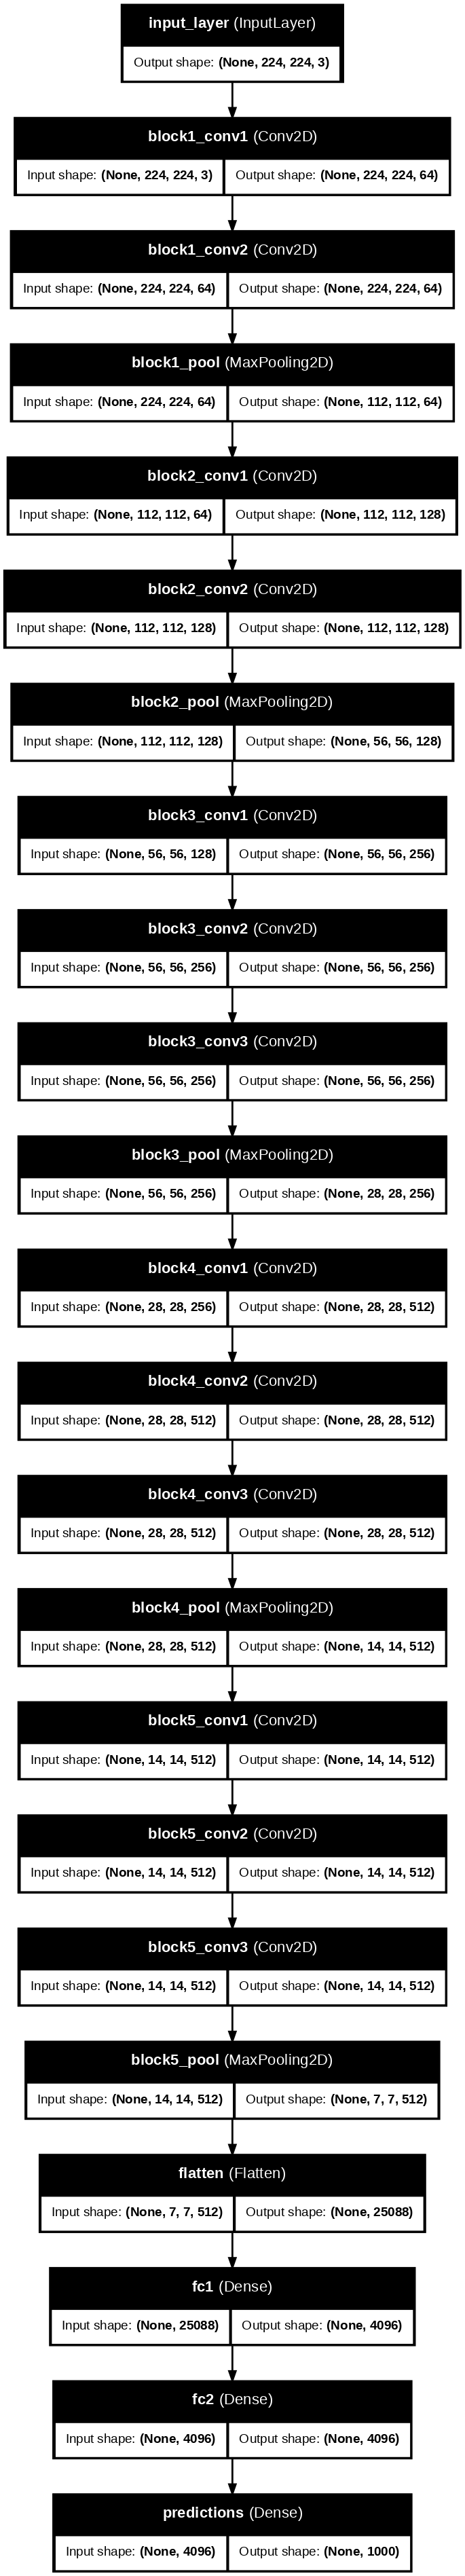

In [12]:
plot_model(model_vgg16, show_shapes=True, show_layer_names=True, dpi=100)

In [13]:
total_trainable_params = sum(layer.count_params() for layer in model_vgg16.layers if layer.trainable)
print(f"Total trainable parameters: {total_trainable_params}")

Total trainable parameters: 138357544


**Trainable Parameters** => It means the weights or learned weights/parameters updated by optimization methods during the training process in a neural network model. These are the parameters that enable the model to learn from training data and directly affect its performance.

**Untrainable Parameters** => These are the parameters that are not updated during the training process in the neural network model. These are generally parameters that indirectly contribute to the learning process of the model, such as constant values ​​to support the structure of the model or values ​​determined by us.

ChatGPT-3 => 175B parameter owned.
ChatGPT-4 => has  1.8trillion parameters  Train-Time: 3 months, 8000 TPU used

In [14]:
predicted_classes = visualise_preds_vgg16(model_vgg16, img_list, True)

Output hidden; open in https://colab.research.google.com to view.

In [15]:
print_predicted_classes(predicted_classes)

trombone.jpeg: trombone (0.92%)
hen.jpeg: cock (0.61%)
Tibetan_mastiff.jpeg: Tibetan_mastiff (1.00%)
brambling.jpeg: ptarmigan (0.32%)
prayer_rug.jpeg: prayer_rug (0.98%)
Eskimo_dog.jpeg: Eskimo_dog (0.49%)
malamute.jpeg: German_shepherd (0.23%)
tiger_shark.jpeg: tiger_shark (0.97%)
trailer_truck.jpeg: moving_van (0.56%)
stingray.jpeg: electric_ray (0.94%)


## Xception

In [16]:
from keras.applications.xception import Xception, preprocess_input as preprocess_input_xception, decode_predictions as decode_xception

def preprocess_xception(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input_xception(img_array)
    return img_array

In [17]:
def predict_xception(model, img_array):

    predictions = model.predict(img_array, verbose=0)

    top_predictions = decode_xception(predictions, top=1)[0][0]

    label, probability = top_predictions[1], top_predictions[2]

    return label, probability

In [18]:
def visualise_preds_xception(model, image_paths, visualize=False):
    results = {}
    
    for img_path in image_paths:
        img_array = preprocess_xception(img_path)
        label, probability = predict_xception(model, img_array)
        results[img_path] = (label, probability)
        
        if visualize:
            plt.figure(figsize=(5, 5))
            plt.imshow(image.load_img(img_path))
            plt.title(f"Predicted: {label} ({probability:.2f}%)")
            plt.axis('off')
            plt.show()

    return results

In [19]:
model_xception = Xception(weights='imagenet')

predicted_classes = visualise_preds_xception(model_xception, img_list, True)

Output hidden; open in https://colab.research.google.com to view.

In [20]:
print_predicted_classes(predicted_classes)

trombone.jpeg: trombone (0.83%)
hen.jpeg: hen (0.67%)
Tibetan_mastiff.jpeg: Tibetan_mastiff (0.96%)
brambling.jpeg: brambling (0.68%)
prayer_rug.jpeg: prayer_rug (0.84%)
Eskimo_dog.jpeg: Eskimo_dog (0.66%)
malamute.jpeg: malamute (0.49%)
tiger_shark.jpeg: tiger_shark (0.91%)
trailer_truck.jpeg: trailer_truck (0.81%)
stingray.jpeg: stingray (0.59%)


## ResNet50(ResidualNetwork)

In [21]:
from keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_input_resnet50, decode_predictions as decode_resnet50

def preprocess_resnet50(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input_resnet50(img_array)
    return img_array

def predict_resnet50(model, img_array):
    predictions = model.predict(img_array, verbose=0)
    top_predictions = decode_resnet50(predictions, top=1)[0][0]
    label, probability = top_predictions[1], top_predictions[2]
    return label, probability

def visualise_preds_resnet50(model, image_paths, visualize=False):
    results = {}
    
    for img_path in image_paths:
        img_array = preprocess_resnet50(img_path)
        label, probability = predict_resnet50(model, img_array)
        results[img_path] = (label, probability)
        
        if visualize:
            plt.figure(figsize=(5, 5))
            plt.imshow(image.load_img(img_path))
            plt.title(f"Predicted: {label} ({probability:.2f}%)")
            plt.axis('off')
            plt.show()

    return results

In [22]:
model_resnet50 = ResNet50(weights='imagenet')

predicted_classes = visualise_preds_resnet50(model_resnet50, img_list, True)

Output hidden; open in https://colab.research.google.com to view.

In [23]:
print_predicted_classes(predicted_classes)

trombone.jpeg: trombone (0.97%)
hen.jpeg: cock (0.80%)
Tibetan_mastiff.jpeg: Tibetan_mastiff (1.00%)
brambling.jpeg: brambling (0.93%)
prayer_rug.jpeg: prayer_rug (1.00%)
Eskimo_dog.jpeg: Eskimo_dog (0.55%)
malamute.jpeg: Eskimo_dog (0.50%)
tiger_shark.jpeg: tiger_shark (0.96%)
trailer_truck.jpeg: moving_van (0.69%)
stingray.jpeg: electric_ray (0.71%)


## InceptionResNetV2

In [24]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as preprocess_input_inceptionresnetv2, decode_predictions as decode_inceptionresnetv2

def preprocess_inception_resnet_v2(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input_inceptionresnetv2(img_array)
    return img_array

def predict_inception_resnet_v2(model, img_array):
    predictions = model.predict(img_array, verbose=0)
    top_predictions = decode_inceptionresnetv2(predictions, top=1)[0][0]
    label, probability = top_predictions[1], top_predictions[2]
    return label, probability

def visualise_preds_inception_resnet_v2(model, image_paths, visualize=False):
    results = {}
    
    for img_path in image_paths:
        img_array = preprocess_inception_resnet_v2(img_path)
        label, probability = predict_inception_resnet_v2(model, img_array)
        results[img_path] = (label, probability)
        
        if visualize:
            plt.figure(figsize=(5, 5))
            plt.imshow(image.load_img(img_path))
            plt.title(f"Predicted: {label} ({probability:.2f}%)")
            plt.axis('off')
            plt.show()

    return results

In [25]:
model_inception_resnet = InceptionResNetV2(weights='imagenet')

predicted_classes = visualise_preds_inception_resnet_v2(model_inception_resnet, img_list, True)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
print_predicted_classes(predicted_classes)

trombone.jpeg: trombone (0.86%)
hen.jpeg: hen (0.89%)
Tibetan_mastiff.jpeg: Tibetan_mastiff (0.89%)
brambling.jpeg: brambling (0.84%)
prayer_rug.jpeg: prayer_rug (0.90%)
Eskimo_dog.jpeg: Eskimo_dog (0.55%)
malamute.jpeg: malamute (0.59%)
tiger_shark.jpeg: tiger_shark (0.94%)
trailer_truck.jpeg: trailer_truck (0.75%)
stingray.jpeg: electric_ray (0.57%)


## DenseNet

In [27]:
from keras.applications.densenet import DenseNet121, preprocess_input as preprocess_input_densenet121, decode_predictions as decode_densenet121

def preprocess_densenet(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input_densenet121(img_array)
    return img_array

def predict_densenet(model, img_array):
    predictions = model.predict(img_array, verbose=0)
    top_predictions = decode_densenet121(predictions, top=1)[0][0]
    label, probability = top_predictions[1], top_predictions[2]
    return label, probability

def visualise_preds_densenet(model, image_paths, visualize=False):
    results = {}
    
    for img_path in image_paths:
        img_array = preprocess_densenet(img_path)
        label, probability = predict_densenet(model, img_array)
        results[img_path] = (label, probability)
        
        if visualize:
            plt.figure(figsize=(5, 5))
            plt.imshow(image.load_img(img_path))
            plt.title(f"Predicted: {label} ({probability:.2f}%)")
            plt.axis('off')
            plt.show()

    return results

In [28]:
model_densenet = DenseNet121(weights='imagenet')

predicted_classes = visualise_preds_densenet(model_densenet, img_list, True)

Output hidden; open in https://colab.research.google.com to view.

In [29]:
print_predicted_classes(predicted_classes)

trombone.jpeg: trombone (0.79%)
hen.jpeg: cock (0.52%)
Tibetan_mastiff.jpeg: Tibetan_mastiff (1.00%)
brambling.jpeg: brambling (0.40%)
prayer_rug.jpeg: prayer_rug (1.00%)
Eskimo_dog.jpeg: Eskimo_dog (0.65%)
malamute.jpeg: Norwegian_elkhound (0.27%)
tiger_shark.jpeg: tiger_shark (0.86%)
trailer_truck.jpeg: trailer_truck (0.65%)
stingray.jpeg: electric_ray (0.92%)


## MobilNetV2

In [30]:
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as preprocess_input_mobilenetv2, decode_predictions as decode_mobilenetv2

def preprocess_mobilenet(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input_mobilenetv2(img_array)
    return img_array

def predict_mobilenet(model, img_array):
    predictions = model.predict(img_array, verbose=0)
    top_predictions = decode_mobilenetv2(predictions, top=1)[0][0]
    label, probability = top_predictions[1], top_predictions[2]
    return label, probability

def visualise_preds_mobilenet(model, image_paths, visualize=False):
    results = {}
    
    for img_path in image_paths:
        img_array = preprocess_mobilenet(img_path)
        label, probability = predict_mobilenet(model, img_array)
        results[img_path] = (label, probability)
        
        if visualize:
            plt.figure(figsize=(5, 5))
            plt.imshow(image.load_img(img_path))
            plt.title(f"Predicted: {label} ({probability:.2f}%)")
            plt.axis('off')
            plt.show()

    return results

In [31]:
model_mobilenet_v2 = MobileNetV2(weights='imagenet')

predicted_classes = visualise_preds_mobilenet(model_mobilenet_v2, img_list, True)

Output hidden; open in https://colab.research.google.com to view.

In [32]:
print_predicted_classes(predicted_classes)

trombone.jpeg: trombone (0.98%)
hen.jpeg: hen (0.44%)
Tibetan_mastiff.jpeg: Tibetan_mastiff (0.97%)
brambling.jpeg: brambling (0.70%)
prayer_rug.jpeg: prayer_rug (0.83%)
Eskimo_dog.jpeg: Eskimo_dog (0.54%)
malamute.jpeg: Norwegian_elkhound (0.26%)
tiger_shark.jpeg: tiger_shark (0.83%)
trailer_truck.jpeg: trailer_truck (0.84%)
stingray.jpeg: electric_ray (0.41%)


## EfficientNetB0

In [33]:
from keras.applications.efficientnet import EfficientNetB0, preprocess_input as preprocess_input_efficientnetb0, decode_predictions as decode_efficientnetb0
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def preprocess_efficientnetb0(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input_efficientnetb0(img_array)
    return img_array

def predict_efficientnetb0(model, img_array):
    predictions = model.predict(img_array, verbose=0)
    top_predictions = decode_efficientnetb0(predictions, top=1)[0][0]
    label, probability = top_predictions[1], top_predictions[2]
    return label, probability

def visualise_preds_efficientnetb0(model, image_paths, visualize=False):
    results = {}
    
    for img_path in image_paths:
        img_array = preprocess_efficientnetb0(img_path)
        label, probability = predict_efficientnetb0(model, img_array)
        results[img_path] = (label, probability)
        
        if visualize:
            plt.figure(figsize=(5, 5))
            plt.imshow(image.load_img(img_path))
            plt.title(f"Predicted: {label} ({probability:.2f}%)")
            plt.axis('off')
            plt.show()

    return results

In [34]:
model_efficientnet = EfficientNetB0(weights='imagenet')

predicted_classes = visualise_preds_efficientnetb0(model_efficientnet, img_list, True)

Output hidden; open in https://colab.research.google.com to view.

In [35]:
print_predicted_classes(predicted_classes)

trombone.jpeg: trombone (0.95%)
hen.jpeg: hen (0.46%)
Tibetan_mastiff.jpeg: Tibetan_mastiff (0.98%)
brambling.jpeg: brambling (0.28%)
prayer_rug.jpeg: prayer_rug (0.65%)
Eskimo_dog.jpeg: Siberian_husky (0.44%)
malamute.jpeg: Norwegian_elkhound (0.31%)
tiger_shark.jpeg: tiger_shark (0.84%)
trailer_truck.jpeg: trailer_truck (0.73%)
stingray.jpeg: electric_ray (0.44%)


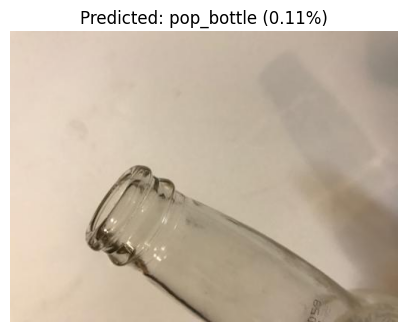

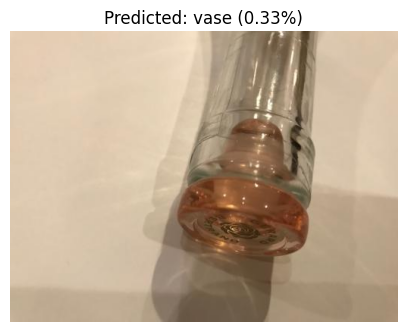

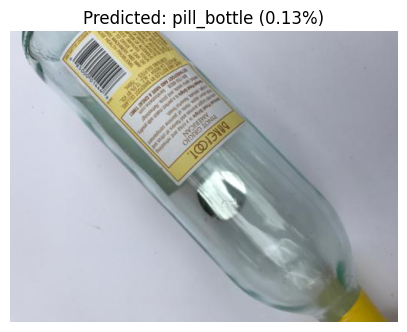

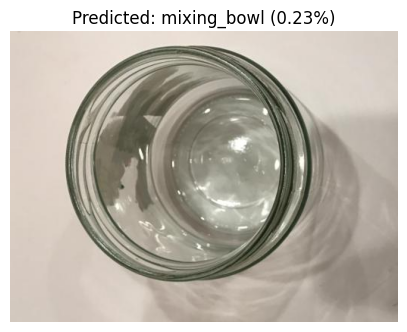

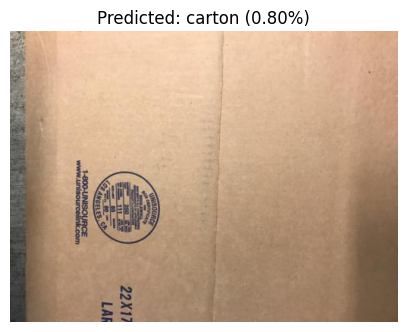

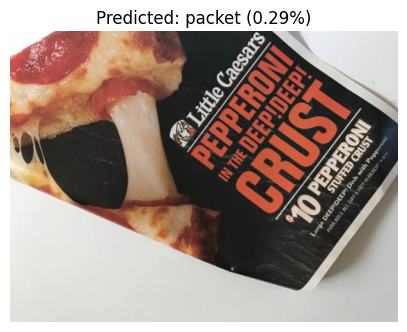

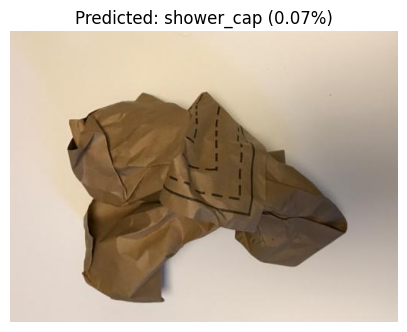

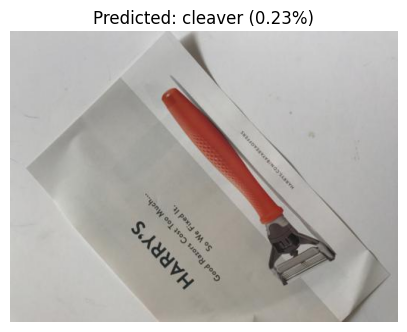

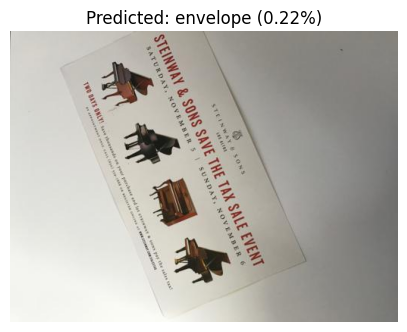

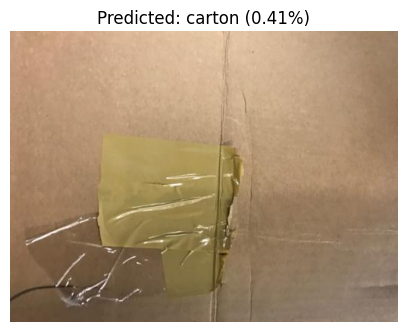

In [36]:
garbage_dir = "../Garbage classification"
garbage_img_list = get_image_paths(garbage_dir, 10)
predicted_classes = visualise_preds_efficientnetb0(model_efficientnet, garbage_img_list, True)

## COMPARE ALL MODELS

In [37]:
from keras.applications.vgg16 import VGG16, preprocess_input as preprocess_input_vgg16, decode_predictions as decode_vgg16
from keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_input_resnet50, decode_predictions as decode_resnet50
from keras.applications.inception_v3 import InceptionV3, preprocess_input as preprocess_input_inceptionv3, decode_predictions as decode_inceptionv3
from keras.applications.xception import Xception, preprocess_input as preprocess_input_xception, decode_predictions as decode_xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as preprocess_input_inceptionresnetv2, decode_predictions as decode_inceptionresnetv2
from keras.applications.densenet import DenseNet121, preprocess_input as preprocess_input_densenet121, decode_predictions as decode_densenet121
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as preprocess_input_mobilenetv2, decode_predictions as decode_mobilenetv2
from keras.applications.efficientnet import EfficientNetB0, preprocess_input as preprocess_input_efficientnetb0, decode_predictions as decode_efficientnetb0


def model_predict(model, img_array):
    return model.predict(img_array, verbose=0)

def predict_main(models, image_paths):
    results = {}
    
    for img_path in image_paths:
        filename = img_path.split('/')[-1]

        results[filename] = {}

        for model_name, model_details in models.items():
            model, target_size, preprocess_input_func, decode_predictions_func = model_details
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img)
            img_array = preprocess_input_func(img_array[np.newaxis, ...])

            preds = model_predict(model, img_array)
            top_pred = decode_predictions_func(preds, top=1)[0][0]
            
            label, probability = top_pred[1], top_pred[2]
            results[filename][model_name] = (label, probability)

    return results


models = {
    'VGG16': (VGG16(weights='imagenet'), (224, 224), preprocess_input_vgg16, decode_vgg16),
    'ResNet50': (ResNet50(weights='imagenet'), (224, 224), preprocess_input_resnet50, decode_resnet50),
    'InceptionV3': (InceptionV3(weights='imagenet'), (299, 299), preprocess_input_inceptionv3, decode_inceptionv3),
    'Xception': (Xception(weights='imagenet'), (299, 299), preprocess_input_xception, decode_xception),
    'InceptionResNetV2': (InceptionResNetV2(weights='imagenet'), (299, 299), preprocess_input_inceptionresnetv2, decode_inceptionresnetv2),
    'DenseNet121': (DenseNet121(weights='imagenet'), (224, 224), preprocess_input_densenet121, decode_densenet121),
    'MobileNetV2': (MobileNetV2(weights='imagenet'), (224, 224), preprocess_input_mobilenetv2, decode_mobilenetv2),
    'EfficientNetB0': (EfficientNetB0(weights='imagenet'), (224, 224), preprocess_input_efficientnetb0, decode_efficientnetb0)
}

# Line of code used in main function
predicted_classes = predict_main(models, garbage_img_list)

for filename, model_results in predicted_classes.items():
    print(f"{filename}:")
    for model_name, (label, probability) in model_results.items():
        print(f"  {model_name}: {label} ({probability:.2f})")

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


glass403.jpg:
  VGG16: screwdriver (0.08)
  ResNet50: pop_bottle (0.41)
  InceptionV3: pop_bottle (0.18)
  Xception: pop_bottle (0.41)
  InceptionResNetV2: pop_bottle (0.46)
  DenseNet121: water_bottle (0.32)
  MobileNetV2: pop_bottle (0.18)
  EfficientNetB0: pop_bottle (0.11)
glass469.jpg:
  VGG16: perfume (0.22)
  ResNet50: vase (0.26)
  InceptionV3: beaker (0.09)
  Xception: vase (0.14)
  InceptionResNetV2: beaker (0.13)
  DenseNet121: water_jug (0.19)
  MobileNetV2: beaker (0.63)
  EfficientNetB0: vase (0.33)
glass435.jpg:
  VGG16: screwdriver (0.16)
  ResNet50: wine_bottle (0.29)
  InceptionV3: vacuum (0.08)
  Xception: lighter (0.09)
  InceptionResNetV2: water_bottle (0.45)
  DenseNet121: sunscreen (0.50)
  MobileNetV2: pill_bottle (0.15)
  EfficientNetB0: pill_bottle (0.13)
glass356.jpg:
  VGG16: spotlight (0.43)
  ResNet50: spotlight (0.46)
  InceptionV3: goblet (0.14)
  Xception: mixing_bowl (0.53)
  InceptionResNetV2: spotlight (0.39)
  DenseNet121: spotlight (0.97)
  MobileN

# PreTrained Models with PyTorch
- TorchVision was used

## Imports

In [38]:
import keras
import tensorflow as tf
from glob import glob
import random, os, datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

## Functions

In [39]:
def get_image_paths(root_dir, num_images=None):
    all_images = []
    
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
        
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))

def display_images(img_list):
    plt.figure(figsize=(15, 6))
    
    for i, img_path in enumerate(img_list):
        img = image.load_img(img_path)
        img = image.img_to_array(img, dtype=np.uint8)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.squeeze())
        plt.axis('off')
        plt.title(f'Image {i+1}')
        
    plt.tight_layout()
    plt.show()


def print_predicted_classes(predicted_classes):
    for full_path, (label, probability) in predicted_classes.items():
        filename = os.path.basename(full_path)
        print(f"{filename}: {label} ({probability:.2f}%)")

## Data

In [40]:
imagenet_label_path ="../imagenet_classes.txt"

In [41]:
dir_path = "../imagenet_samples/"
img_list = get_image_paths(dir_path, 10)

## ResNet50

In [42]:
import torch
from PIL import Image

from torchvision import models, transforms
from torchvision.models import ResNet50_Weights

In [43]:
def predict(model, input_batch):
    with torch.no_grad(): # Setting that prevents the model from calculating unnecessary gradients.
        if torch.cuda.is_available():
            input_batch = input_batch.to('cuda')
            model.to('cuda')
        output = model(input_batch)
    return output

def read_imagenet_labels(imagenet_labels_path):
    with open(imagenet_labels_path, "r") as f:
        categories = [s.strip() for s in f.readlines()]
    return categories

def get_top_category(probabilities, categories):
    top_prob, top_catid = torch.topk(probabilities, 1)
    return categories[top_catid[0]], top_prob[0].item()


In [44]:
def main(image_paths, imagenet_labels_path):

    weights = ResNet50_Weights.DEFAULT
    preprocess = weights.transforms() # It contains the pre-processing function of the relevant model.

    model = models.resnet50(weights=weights)
    model.eval() # It puts the model in evaluation mode. In other words, it disables some features in train mode.

    categories = read_imagenet_labels(imagenet_labels_path)

    results = {}
    
    for image_path in image_paths:
        input_image = Image.open(image_path).convert('RGB')

        input_tensor = preprocess(input_image)

        input_batch = input_tensor.unsqueeze(0) # dimension addition process shall be used.

        output = predict(model, input_batch)

        probabilities = torch.nn.functional.softmax(output[0], dim=0)

        category, probability = get_top_category(probabilities, categories)
        print(f"{category}: {probability}")

main(img_list, imagenet_label_path)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 93.3MB/s]


ostrich: 0.39454686641693115
bulbul: 0.5465947389602661
malamute: 0.4961620569229126
Saint Bernard: 0.34739601612091064
puck: 0.5478532910346985
trimaran: 0.10667485743761063
electric ray: 0.2582934498786926
screwdriver: 0.18658334016799927
triumphal arch: 0.5085961222648621
electric ray: 0.3292078971862793


## DenseNet

In [45]:
available_models = [model for model in dir(models) if not model.startswith("__")]

In [46]:
print("Available image classification models in torchvision:")
for model in available_models:
    print(model)

# DenseNet121_Weights

Available image classification models in torchvision:
AlexNet
AlexNet_Weights
ConvNeXt
ConvNeXt_Base_Weights
ConvNeXt_Large_Weights
ConvNeXt_Small_Weights
ConvNeXt_Tiny_Weights
DenseNet
DenseNet121_Weights
DenseNet161_Weights
DenseNet169_Weights
DenseNet201_Weights
EfficientNet
EfficientNet_B0_Weights
EfficientNet_B1_Weights
EfficientNet_B2_Weights
EfficientNet_B3_Weights
EfficientNet_B4_Weights
EfficientNet_B5_Weights
EfficientNet_B6_Weights
EfficientNet_B7_Weights
EfficientNet_V2_L_Weights
EfficientNet_V2_M_Weights
EfficientNet_V2_S_Weights
GoogLeNet
GoogLeNetOutputs
GoogLeNet_Weights
Inception3
InceptionOutputs
Inception_V3_Weights
MNASNet
MNASNet0_5_Weights
MNASNet0_75_Weights
MNASNet1_0_Weights
MNASNet1_3_Weights
MaxVit
MaxVit_T_Weights
MobileNetV2
MobileNetV3
MobileNet_V2_Weights
MobileNet_V3_Large_Weights
MobileNet_V3_Small_Weights
RegNet
RegNet_X_16GF_Weights
RegNet_X_1_6GF_Weights
RegNet_X_32GF_Weights
RegNet_X_3_2GF_Weights
RegNet_X_400MF_Weights
RegNet_X_800MF_Weights
RegNet

In [47]:
from torchvision.models import DenseNet121_Weights

In [48]:
def predict(model, input_batch):
    with torch.no_grad():
        if torch.cuda.is_available():
            input_batch = input_batch.to('cuda')
            model.to('cuda')
        output = model(input_batch)
    return output

def read_imagenet_labels(imagenet_labels_path):
    with open(imagenet_labels_path, "r") as f:
        categories = [s.strip() for s in f.readlines()]
    return categories

def get_top_category(probabilities, categories):
    top_prob, top_catid = torch.topk(probabilities, 1)
    return categories[top_catid[0]], top_prob[0].item()

def main(image_paths, imagenet_labels_path):

    weights = DenseNet121_Weights.DEFAULT
    preprocess = weights.transforms()

    model = models.densenet121(weights=weights)
    model.eval()

    categories = read_imagenet_labels(imagenet_labels_path)

    results = {}
    
    for image_path in image_paths:
        input_image = Image.open(image_path).convert('RGB')

        input_tensor = preprocess(input_image)

        input_batch = input_tensor.unsqueeze(0)

        output = predict(model, input_batch)

        probabilities = torch.nn.functional.softmax(output[0], dim=0)

        category, probability = get_top_category(probabilities, categories)
        print(f"{category}: {probability}")

In [49]:
main(img_list, imagenet_label_path)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 113MB/s]


ostrich: 0.9993446469306946
bulbul: 0.9925040006637573
malamute: 0.6299044489860535
Saint Bernard: 0.989835798740387
puck: 0.9969694018363953
catamaran: 0.767284631729126
electric ray: 0.9780344367027283
power drill: 0.23070557415485382
suit: 0.6068618893623352
electric ray: 0.9459182024002075


## MobileNetV2

In [50]:
from torchvision.models import MobileNet_V2_Weights

In [51]:
def predict(model, input_batch):
    
    with torch.no_grad():
        if torch.cuda.is_available():
            input_batch = input_batch.to('cuda')
            model.to('cuda')
        output = model(input_batch)
    return output

def read_imagenet_labels(imagenet_labels_path):
    
    with open(imagenet_labels_path, "r") as f:
        categories = [s.strip() for s in f.readlines()]
    return categories

def get_top_category(probabilities, categories):
    top_prob, top_catid = torch.topk(probabilities, 1)
    
    return categories[top_catid[0]], top_prob[0].item()

def main(image_paths, imagenet_labels_path):

    weights = MobileNet_V2_Weights.DEFAULT
    preprocess = weights.transforms()

    model = models.mobilenet_v2(weights=weights)
    model.eval()

    categories = read_imagenet_labels(imagenet_labels_path)

    results = {}
    
    for image_path in image_paths:
        input_image = Image.open(image_path).convert('RGB')

        input_tensor = preprocess(input_image)

        input_batch = input_tensor.unsqueeze(0)

        output = predict(model, input_batch)

        probabilities = torch.nn.functional.softmax(output[0], dim=0)

        category, probability = get_top_category(probabilities, categories)
        print(f"{category}: {probability}")

In [52]:
main(img_list, imagenet_label_path)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 31.2MB/s]


ostrich: 0.7133358120918274
bulbul: 0.6655057668685913
malamute: 0.12821152806282043
Saint Bernard: 0.3425247371196747
puck: 0.4840509593486786
catamaran: 0.3255045413970947
electric ray: 0.49143558740615845
hard disc: 0.04433304816484451
triumphal arch: 0.19584329426288605
electric ray: 0.3441493809223175


## EffiicientNetV2

In [53]:
from torchvision.models import EfficientNet_V2_S_Weights

In [54]:
def predict(model, input_batch):
    with torch.no_grad():
        if torch.cuda.is_available():
            input_batch = input_batch.to('cuda')
            model.to('cuda')
        output = model(input_batch)
    return output

def read_imagenet_labels(imagenet_labels_path):
    
    with open(imagenet_labels_path, "r") as f:
        categories = [s.strip() for s in f.readlines()]
        
    return categories

def get_top_category(probabilities, categories):
    
    top_prob, top_catid = torch.topk(probabilities, 1)
    
    return categories[top_catid[0]], top_prob[0].item()

def main(image_paths, imagenet_labels_path):

    weights = EfficientNet_V2_S_Weights.DEFAULT
    preprocess = weights.transforms()

    model = models.efficientnet_v2_s(weights=weights)
    model.eval()

    categories = read_imagenet_labels(imagenet_labels_path)

    results = {}
    
    for image_path in image_paths:
        input_image = Image.open(image_path).convert('RGB')

        input_tensor = preprocess(input_image)

        input_batch = input_tensor.unsqueeze(0)

        output = predict(model, input_batch)

        probabilities = torch.nn.functional.softmax(output[0], dim=0)

        category, probability = get_top_category(probabilities, categories)
        print(f"{category}: {probability}")

In [55]:
main(img_list, imagenet_label_path)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 146MB/s]


ostrich: 0.7266486883163452
bulbul: 0.7717459797859192
malamute: 0.7678870558738708
Saint Bernard: 0.8507598042488098
puck: 0.7896238565444946
trimaran: 0.6317738890647888
electric ray: 0.8248609304428101
screwdriver: 0.3981930911540985
triumphal arch: 0.8004856705665588
stingray: 0.5085305571556091
